<a href="https://colab.research.google.com/github/Carapet07/Data-Science-projects/blob/main/Facial_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset: https://www.kaggle.com/datasets/msambare/fer2013/data

### In this project, I will develop a facial emotion recognition model using the FER2013 dataset. This dataset contains images of human faces, each labeled with one of 7 different emotions: Angry, Disgust, Fear, Happy, Sad, Surprise, and Neutral. The data is already divided into training and testing categories, allowing for efficient model evaluation and performance measurement.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
# upload kaggle's json file
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"romacarapetean","key":"a46e24d04f7f0717c08d7cd4f8fbb24e"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download the dataset
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

Data preprocessing including data augumentaton

I won't add zoom_range and rotation_range because they make emotions less recognizable

In [4]:
train_dir = 'test/'
test_dir = 'train/'

print(os.listdir(train_dir))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(48, 48),
                                                    batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(48, 48),
                                                    batch_size=32, class_mode='categorical')

['fear', 'disgust', 'neutral', 'sad', 'surprise', 'happy', 'angry']
Found 7178 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


In [5]:
num_batches = len(train_generator)
print(f"Number of batches in train_generator: {num_batches}")

Number of batches in train_generator: 225


Why the length of train_generator is only 225 whereas above we can see 'Found 7178 images belonging to 7 classes'. So it is because len function works on a generator object and returns the total number of batches

For a directory with N images and a batch_size of B, the number of batches is aproximately N/B.


7178 / 32 = 224.31

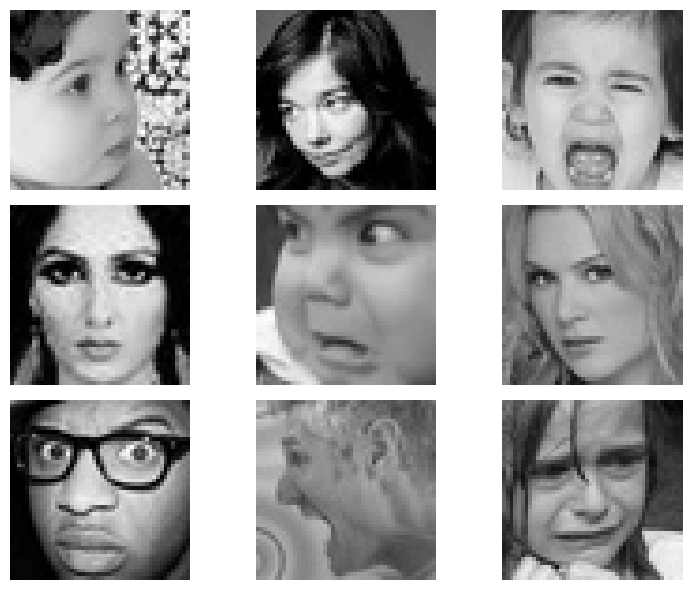

In [6]:
rows, cols = 3, 3

fig, axes = plt.subplots(rows, cols, figsize=(8, 6))

imgs, labels = next(test_generator)

for i, ax in enumerate(axes.flat):
  if i < len(imgs): # check if we don't exceed the batch size
    ax.imshow(imgs[i])
    ax.axis('off')


plt.tight_layout()
plt.show()

Check the number of channels in the images

In [7]:
batch = next(train_generator)
images, labels = batch

print(images.shape)

(32, 48, 48, 3)


Make the model

I will use residual connection which allow us to slide the gradients through the model to save its weights

The bias term in the layers will be turned off because I will use BatchNormalization which includes its own offset(Beta), making the layer's bias redundant

GlobalAveragePooling2D layer replaces Flatten. Why? Flatten layer produces a large of features that often require a Dense layer afterward, resulting in a high number of parameters. GlobalAveragePooling drastically reduces the number of features, making the model lighter and less prone to overfitting


In [32]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint

inputs = layers.Input(shape=(48, 48, 3))
x = layers.Conv2D(filters=32, kernel_size=5, activation='relu', use_bias=False,
                  kernel_regularizer=l2(1e-4),)(inputs)

for filters in [32, 64, 128, 256]:
  residual = x # add residual connection

  x = layers.Conv2D(filters, kernel_size=3, padding='same', use_bias=False,
                    kernel_regularizer=l2(1e-4))(x)
  x = LeakyReLU()(x)
  x = layers.BatchNormalization()(x)


  x = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(x)
  x = layers.Dropout(0.25)(x)



  residual = layers.Conv2D(filters, 1, strides=2, padding='same', use_bias=False)(residual)
  x = layers.add([x, residual])


x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [33]:
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

In [34]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_generator, validation_data=test_generator, epochs=50,
                    callbacks=[checkpoint_callback, reduce_lr])

Epoch 1/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1408 - loss: 3.1886
Epoch 1: val_accuracy improved from -inf to 0.18412, saving model to model_weights.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - accuracy: 0.1409 - loss: 3.1874 - val_accuracy: 0.1841 - val_loss: 2.2015 - learning_rate: 1.0000e-04
Epoch 2/50
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1806 - loss: 2.7486
Epoch 2: val_accuracy improved from 0.18412 to 0.21223, saving model to model_weights.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 36s 142ms/step - accuracy: 0.1806 - loss: 2.7481 - val_accuracy: 0.2122 - val_loss: 2.3529 - learning_rate: 1.0000e-04
Epoch 3/50
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1911 - loss: 2.5727
Epoch 3: val_accuracy improved from 0.21223 to 0.26619, saving model to model_weights.weights.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.1911 - loss: 2.5723 - val_accuracy: 0.2662 - val_loss: 1.9211 - learning_rate: 1.0000e-04
Epoch 4/

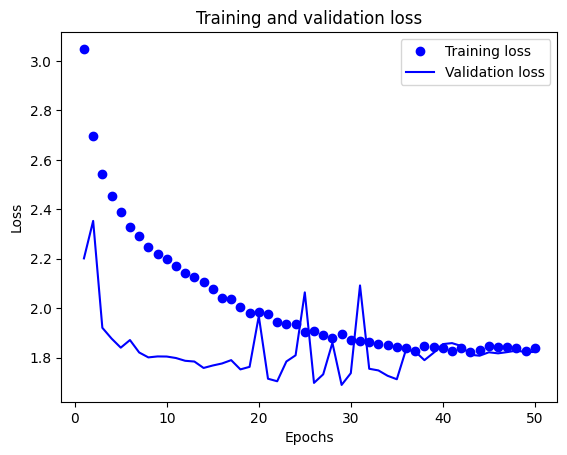

In [35]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

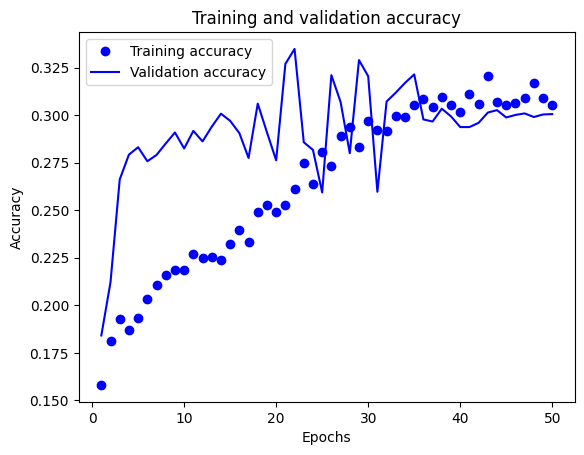

In [36]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Trying another approach: a pretrained model MobileNetV2

MobileNetV2 require images to be normalized in range between -1 and 1 so i will implement a new generator

In [37]:
def rescale_to_minusone_one(img):
  return img / 127.5 - 1

train_datagen2 = ImageDataGenerator(
    preprocessing_function=rescale_to_minusone_one,
    #rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator2 = train_datagen2.flow_from_directory(train_dir, target_size=(48, 48),
                                                      batch_size=32, class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [38]:
base_model = keras.applications.MobileNetV2(input_shape=(48, 48, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model2 = keras.Model(inputs=base_model.input, outputs=outputs)

model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model2.fit(train_generator2, validation_data=test_generator, epochs=50)

<ipython-input-38-708ba252c57d>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(input_shape=(48, 48, 3), include_top=False, weights='imagenet')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 35s 128ms/step - accuracy: 0.2077 - loss: 2.5017 - val_accuracy: 0.2868 - val_loss: 1.8829
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step - accuracy: 0.2713 - loss: 2.0128 - val_accuracy: 0.3060 - val_loss: 1.8552
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 48s 135ms/step - accuracy: 0.3056 - loss: 1.8642 - val_accuracy: 0.2943 - val_loss: 1.8775
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 23s 103ms/step - accuracy: 0.3082 - loss: 1.8337 - val_accuracy: 0.3034 - val_loss: 1.8235
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 49s 136ms/step - accuracy: 0.3172 - loss: 1.7613 - val_accuracy: 0.2960 - val_loss: 1.8447
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.3344 - loss: 1.7555 - val_accuracy: 0.3295 - val_loss: 1.7274
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - accuracy: 0.3281 - loss: 1.7305 - val_accuracy: 0.2985 - val_loss: 1.8149
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - accuracy: 0.3341 - loss: 1.7448 - val

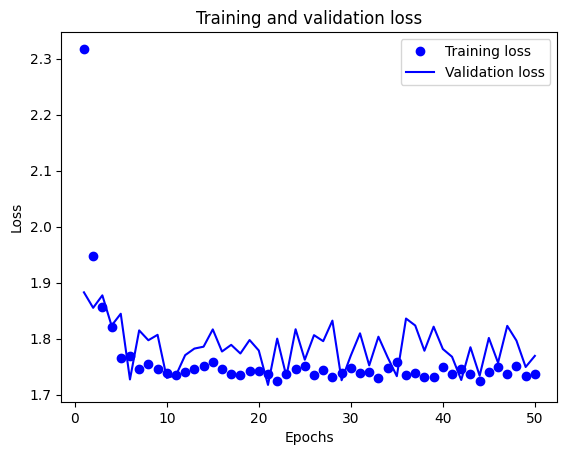

In [39]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

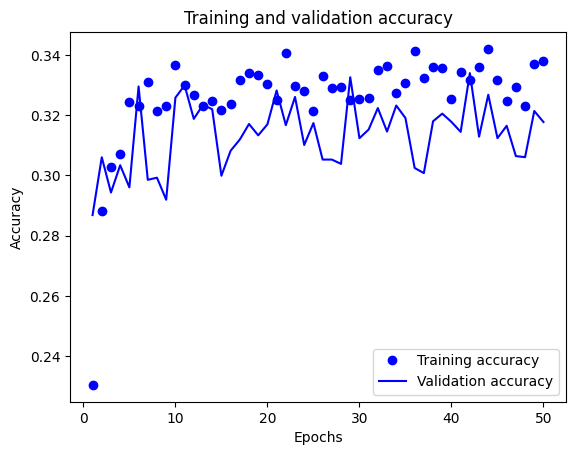

In [40]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()